# Mantenimiento Predictivo - Data Ingestion
Intento seguir los pasos de este ejemplo:
https://github.com/Azure-Samples/MachineLearningSamples-PredictiveMaintenance/blob/master/Code/1_data_ingestion.ipynb

# Data Load
Se utilizan datasets preparados en MP1 y MP2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import datetime

In [3]:
import re

In [4]:
import warnings
warnings.filterwarnings("ignore", category=Warning)

In [5]:
# Seteos de Pandas para ver mejor la info. https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html
# In max_columns and max_rows ‘None’ value means unlimited.
pd.set_option('display.max_rows', 100)
# Conviene setear min_rows también porque cuando se superan las max_rows, sólo muestra la cantidad indicada en min_rows.
pd.set_option('display.min_rows', 10)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_colwidth = 100
pd.options.display.float_format = '{:.1f}'.format

In [6]:
#path_data = 'C:\\Users\\COLMO\\OneDrive\\0-Data Science\\data_science\\data_pampa'
path_data = 'C:\\Users\\Usuario\\OneDrive\\0-Data Science\\data_science\\data_pampa'
#path_data = 'C:\\Users\\COLMO\\data_mining\\data_pampa'

## Dataset de tiempo real

In [7]:
file = 'EMA_compresores_5min_AF_ok.csv'
df_hist = pd.read_csv(path_data + '\\' + file, sep=';', encoding='UTF-8', decimal = '.')
df_hist.drop(columns='Unnamed: 0', inplace=True)
df_hist.rename(columns={'carga_matriz': 'carga_motriz'}, inplace=True)
df_hist.timestamp = pd.to_datetime(df_hist.timestamp, format='%Y-%m-%d %H:%M:%S')
df_hist.sort_values(by=['element', 'timestamp'], inplace=True)
print(df_hist.shape)
print(df_hist.dtypes)
df_hist.tail()

(455004, 7)
element                 object
timestamp       datetime64[ns]
press_suc              float64
press_1                float64
rpm                    float64
carga_motriz           float64
press_2                float64
dtype: object


,element,timestamp,press_suc,press_1,rpm,carga_motriz,press_2
404452,K-09,2022-02-23 12:35:00,7.2,19.3,1057.4,96.0,37.1
404451,K-09,2022-02-23 12:40:00,7.2,19.3,1056.8,96.3,37.1
404450,K-09,2022-02-23 12:45:00,7.2,19.3,1057.2,96.3,37.1
404449,K-09,2022-02-23 12:50:00,7.2,19.3,1055.7,95.8,37.1
404448,K-09,2022-02-23 12:55:00,7.2,19.3,1056.1,97.8,37.1


In [8]:
# % Nulos
100*df_hist.isna().sum()/len(df_hist)

element        0.0
timestamp      0.0
press_suc      0.0
press_1        0.0
rpm            0.0
carga_motriz   0.0
press_2        0.0
dtype: float64

## Log de Mantenimiento

In [15]:
file = 'log_mant.csv'
df_log_mant = pd.read_csv(path_data + '\\' + file, sep=';', encoding='latin-1', decimal = '.')
df_log_mant.drop(columns='Unnamed: 0', inplace=True)
df_log_mant.timestamp1 = pd.to_datetime(df_log_mant.timestamp1, format='%Y-%m-%d %H:%M:%S')
df_log_mant.timestamp2 = pd.to_datetime(df_log_mant.timestamp2, format='%Y-%m-%d %H:%M:%S')
df_log_mant.date = pd.to_datetime(df_log_mant.date, format='%Y-%m-%d %H:%M:%S')
print(df_log_mant.shape)
print(df_log_mant.dtypes)
df_log_mant.tail()

(528, 9)
element               object
timestamp1    datetime64[ns]
timestamp2    datetime64[ns]
date          datetime64[ns]
comments              object
mp                     int64
mnp                    int64
fail                   int64
oh                     int64
dtype: object


,element,timestamp1,timestamp2,date,comments,mp,mnp,fail,oh
523,K-09,2022-02-06 12:20:00,2022-02-06 13:05:00,2022-02-06,"12:20hs a 23:55hs,paro por alta presion de cilindro #2 y #4.",0,1,0,0
524,K-09,2022-02-11 00:10:00,2022-02-11 00:15:00,2022-02-11,"00:40hs a 01:15hs mtto cv, cambio de dos valvulas de descarga cil. compresor #1.",0,1,0,0
525,K-09,2022-02-11 06:15:00,2022-02-11 06:25:00,2022-02-11,"00:40hs a 01:15hs mtto cv, cambio de dos valvulas de descarga cil. compresor #1.",0,1,0,0
526,K-09,2022-02-11 12:10:00,2022-02-11 12:15:00,2022-02-11,"00:40hs a 01:15hs mtto cv, cambio de dos valvulas de descarga cil. compresor #1.",0,1,0,0
527,K-09,2022-02-11 20:45:00,2022-02-11 21:05:00,2022-02-11,"00:40hs a 01:15hs mtto cv, cambio de dos valvulas de descarga cil. compresor #1.",0,1,0,0


## Sources
The common data elements for predictive maintenance problems can be summarized as follows:
* Machine features: The features specific to each individual machine, e.g. engine size, make, model, location, installation date.
* Telemetry data: The operating condition data collected from sensors, e.g. temperature, vibration, operating speeds, pressures.
* Maintenance history: The repair history of a machine, e.g. maintenance activities or component replacements, this can also include error code or runtime message logs.
* Failure history: The failure history of a machine or component of interest.

El ejemplo de MS utiliza estos datasets:<br>
**Equipos:** <span style="color:red">*NO* se cuenta con estos datos. Buscar datos de condiciones de operación por compresor</span> <br>
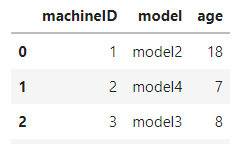 <br>
**Error Log:** The error log contains non-breaking errors recorded while the machine is still operational. These errors are not considered failures, though they may be predictive of a future failure event. **_The error datetime field is rounded to the closest hour since the telemetry data (loaded later) is collected on an hourly rate._** <span style="color:red">estos datos se podrían armar diferenciando del log de zafiro los mant no prog en donde no hubo reparación o paro **aún no se armó este dataset** </span><br>
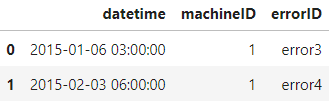<br>

**Maintenance data set:**<br>
The maintenance log contains both scheduled and unscheduled maintenance records.<br>
Scheduled maintenance corresponds with regular inspection of components.<br>
Unscheduled maintenance may arise from mechanical failure or other performance degradations.<br> 
A failure record is generated for component replacement in the case of either maintenance events.<br>
Because maintenance events can also be used to infer component life, the maintenance data has been collected over two years (2014, 2015) instead of only over the year of interest (2015).<br>
<span style="color:red">Se armó un Dataset con el equipo y el timestamp de inicio de un mant prog, mant no prog y las fallas (df_log_mant). </span><br>
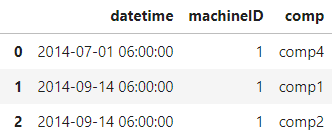

In [16]:
df_log_mant[(df_log_mant.mp==1)|(df_log_mant.mnp==1)][['element', 'timestamp1', 'mp', 'mnp']].head()

,element,timestamp1,mp,mnp
0,K-02,2022-01-10 09:00:00,1,0
1,K-02,2022-02-12 12:10:00,1,0
2,K-02,2022-02-12 14:10:00,1,0
3,K-03,2021-10-03 09:15:00,1,0
4,K-03,2021-12-02 08:45:00,1,0


**Telemetry data set:**
Consists of time-series data (voltage, rotation, pressure, and vibration) sensor measurements collected from each machines in real time. 
<span style="color:red">In the example, the data is averaged over an hour and stored in the telemetry logs.</span><br>
NOTA: por ahora, mantengo los datos en una frecuencia de 5m
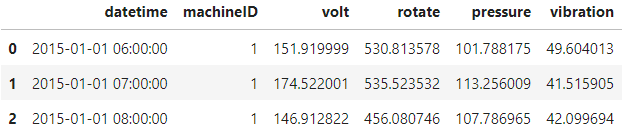

In [17]:
df_hist.head()

,element,timestamp,press_suc,press_1,rpm,carga_motriz,press_2
50555,K-01,2021-09-01 00:00:00,33.1,86.6,1173.6,94.2,87.8
50554,K-01,2021-09-01 00:05:00,33.1,86.6,1173.5,93.8,87.6
50553,K-01,2021-09-01 00:10:00,33.1,86.6,1173.2,95.8,87.6
50552,K-01,2021-09-01 00:15:00,33.1,86.6,1172.9,95.9,87.9
50551,K-01,2021-09-01 00:20:00,33.3,86.6,1173.3,95.4,87.9


# Feature Engineering
The ultimate goal is to combine the different data sources together to generate a single record for each time unit within each asset. The record combines features and labels to be fed into the machine learning algorithm.

# Telemetry Features
We can improve the model performance by aligning our data by aggregating average sensor measures on a tumbling 12 hour window.<br> <span style="color:red">En el ejemplo de MS, pasan de datos horarios a datos cada 12 hs. Si se quisiera pasar a esta frecuencia, habría que cambiar el load de datos desde PI para tener datos mejor calculados. </span><br>
This will directly reduce the computaton time required to do the feature engineering, labeling and modeling required for our solution.

NOTA: hago una prueba de pasar de 5min a 1 h.

In [109]:
# Resample by hour and calculate medians. OJO: Resample elimina features no numéricos
#df_hours = pd.DataFrame(columns=df_hist.columns) No copia los tipos de datos
df_hours = df_hist[df_hist.element.isna()]
df_hours.set_index(keys='timestamp')
lst_elements = df_log_mant[['element']].drop_duplicates().element.to_list()
for element in lst_elements:
    df = df_hist[df_hist.element==element].set_index(keys='timestamp')
    df = df.resample('H').mean()
    df['element'] = element
    df.reset_index(inplace=True)
    df = df[df_hist.columns]
    df_hours = pd.concat([df_hours, df], ignore_index=True)
df_hours.head()

,element,timestamp,press_suc,press_1,rpm,carga_motriz,press_2
0,K-02,2021-09-01 00:00:00,33.2,87.1,1158.4,95.6,87.7
1,K-02,2021-09-01 01:00:00,33.3,87.2,1158.4,95.4,87.8
2,K-02,2021-09-01 02:00:00,33.3,87.2,1158.4,95.5,88.0
3,K-02,2021-09-01 03:00:00,33.3,87.2,1158.3,95.3,88.0
4,K-02,2021-09-01 04:00:00,33.3,87.2,1158.1,95.2,88.0


In [70]:
# Cómo crear un index de tiempo: NO ES NECESARIO EJECUTAR
#df_hours = pd.DataFrame({"Date": pd.date_range(start=df_hist.timestamp.min().date(), end=df_hist.timestamp.max().date(), freq='H')})
#df_hours.head()

,Date
0,2021-09-01 00:00:00
1,2021-09-01 01:00:00
2,2021-09-01 02:00:00
3,2021-09-01 03:00:00
4,2021-09-01 04:00:00


## Lag features
1) Divide the duration of data collection into time units where each record belongs to a single point in time for each asset. The time unit does not have to be the same as the frequency of data collection.
2) Look for trends within measures, over time, in order to predict performance degradation, which we would like to connect to how likely a component will fail --> create features for these trends within each record using time lags over previous observations to check for these performance changes.<br>
    The lag window size  is a hyper parameter that we can optimize.
    * Rolling window approach:
    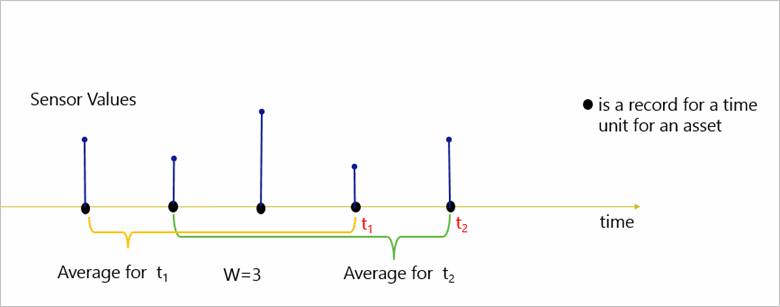
    * Tumbling window approach
    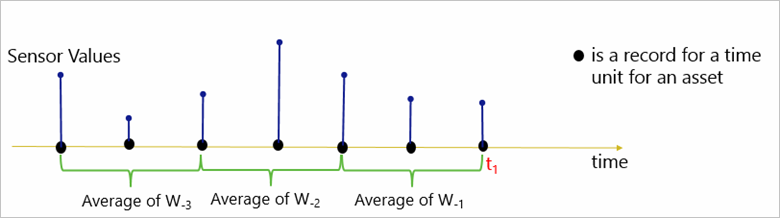
    
**NOTA: armo lags para 12, 24 y 36 horas. El ejemplo calcula mean y std dev**

In [73]:
df_hours.columns

Index(['element', 'timestamp', 'press_suc', 'press_1', 'rpm', 'carga_motriz', 'press_2'], dtype='object')

In [131]:
# We choose windows for our rolling windows 12hrs, 24 hrs and 36 hrs
df_hours_w = df_hours.copy().sort_values(by=['element', 'timestamp'])
df_hours_w.reset_index(drop=True, inplace=True)
lags = [12, 24, 36]
df_hours_w = df_hours_w.assign(**{f'{col}_mean_{lag}': df_hours_w.groupby('element')[col].rolling(min_periods=1, window=lag).mean()\
                                  .reset_index(drop=True)
                                for lag in lags
                                for col in df_hours_w.columns[2:]})
df_hours_w = df_hours_w.assign(**{f'{col}_std_{lag}': df_hours_w.groupby('element')[col].rolling(min_periods=1, window=lag).std()\
                                  .reset_index(drop=True)
                                for lag in lags
                                for col in df_hours_w.columns[2:7]})
df_hours_w.head()
# NOTA: std genera un NaN en el primer registro para cada elemento. Ver cómo tratarlo!!!!!

,element,timestamp,press_suc,press_1,rpm,carga_motriz,press_2,press_suc_mean_12,press_1_mean_12,rpm_mean_12,carga_motriz_mean_12,press_2_mean_12,press_suc_mean_24,press_1_mean_24,rpm_mean_24,carga_motriz_mean_24,press_2_mean_24,press_suc_mean_36,press_1_mean_36,rpm_mean_36,carga_motriz_mean_36,press_2_mean_36,press_suc_std_12,press_1_std_12,rpm_std_12,carga_motriz_std_12,press_2_std_12,press_suc_std_24,press_1_std_24,rpm_std_24,carga_motriz_std_24,press_2_std_24,press_suc_std_36,press_1_std_36,rpm_std_36,carga_motriz_std_36,press_2_std_36
0,K-01,2021-09-01 00:00:00,33.3,86.7,1173.0,95.1,87.9,33.3,86.7,1173.0,95.1,87.9,33.3,86.7,1173.0,95.1,87.9,33.3,86.7,1173.0,95.1,87.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,K-01,2021-09-01 01:00:00,33.3,86.9,1172.7,94.9,88.0,33.3,86.8,1172.9,95.0,87.9,33.3,86.8,1172.9,95.0,87.9,33.3,86.8,1172.9,95.0,87.9,0.1,0.1,0.2,0.1,0.1,0.1,0.1,0.2,0.1,0.1,0.1,0.1,0.2,0.1,0.1
2,K-01,2021-09-01 02:00:00,33.3,86.9,1172.4,95.2,88.1,33.3,86.8,1172.7,95.1,88.0,33.3,86.8,1172.7,95.1,88.0,33.3,86.8,1172.7,95.1,88.0,0.1,0.1,0.3,0.1,0.1,0.1,0.1,0.3,0.1,0.1,0.1,0.1,0.3,0.1,0.1
3,K-01,2021-09-01 03:00:00,33.3,86.9,1172.7,94.9,88.2,33.3,86.8,1172.7,95.0,88.1,33.3,86.8,1172.7,95.0,88.1,33.3,86.8,1172.7,95.0,88.1,0.0,0.1,0.3,0.1,0.2,0.0,0.1,0.3,0.1,0.2,0.0,0.1,0.3,0.1,0.2
4,K-01,2021-09-01 04:00:00,33.3,86.9,1172.6,95.0,88.2,33.3,86.8,1172.7,95.0,88.1,33.3,86.8,1172.7,95.0,88.1,33.3,86.8,1172.7,95.0,88.1,0.0,0.0,0.2,0.1,0.2,0.0,0.0,0.2,0.1,0.2,0.0,0.0,0.2,0.1,0.2


In [78]:
# Para obtener el valor -12 registros atrás: se utiliza .shift
df_hours[df_hours.element=='K-01']['rpm'].shift(12)
# para calcular una ventana, se utiliza rolling. Si coloco min_periods>1, le indico que necesito al menos esa cantidad de registros
# para que se calcule.
df_hours['rpm'].rolling(min_periods=1, window=12).mean()

0       1158.4
1       1158.4
2       1158.4
3       1158.4
4       1158.3
         ...  
37912   1145.2
37913   1146.8
37914   1148.5
37915   1150.2
37916   1151.7
Name: rpm, Length: 37917, dtype: float64

## Days since last replacement from maintenance
Possible features from maintenance dataset can be the number of replacements over time or to calculate how long it has been since a component has been replaced. <br>
Replacement time is expected to correlate better with component failures since the longer a component is used, the more degradation would be expected.